## Importing necessary libraies

In [ ]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt


import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import  ConfusionMatrixDisplay
from keras.utils import plot_model

## EDA and Data Preprocessing

Before we can begin training/testing the model, EDA is required to assess what preprocessing will be needed.

In [ ]:
meta_data = pd.read_csv("/content/drive/My Drive/CancerImages/HAM10000_metadata.csv")

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

is_cancerous = {
    'nv': 0,
    'mel': 1,
    'bkl': 0,
    'bcc': 1,
    'akiec': 0,
    'vasc': 0,
    'df': 0
}

base_skin_dir = '/content/drive/My Drive/CancerImages'


imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}


# Add path to image to meta_data
meta_data['path'] = meta_data['image_id'].map(imageid_path_dict.get)
# Add lesion type to image to meta_data
meta_data['cell_type'] = meta_data['dx'].map(lesion_type_dict.get)
# Convert this to categorical
meta_data['cell_type_idx'] = pd.Categorical(meta_data['cell_type']).codes

# Fill empty ages with mean
meta_data['age'].fillna((meta_data['age'].mean()), inplace=True)

In [ ]:
labels = [ 'akiec', 'bcc','bkl','df','mel', 'nv',  'vasc']

def estimate_weights_mfb(label):
    class_weights = np.zeros_like(label, dtype=float)
    counts = np.zeros_like(label)
    for i,l in enumerate(label):
        counts[i] = meta_data[meta_data['dx']==str(l)]['dx'].value_counts()[0]
    counts = counts.astype(float)
    median_freq = np.median(counts)
    for i, label in enumerate(label):
        class_weights[i] = median_freq / counts[i]
    return class_weights

classweights = estimate_weights_mfb(labels)

classweight_dict = {label: weight for label, weight in zip(labels, classweights)}

meta_data['class_weight'] = meta_data['dx'].map(classweight_dict.get)

## Setup for ML
Need to to add images to the dataset.

Then need to split into train/validation/test sets.


In [ ]:
df = meta_data.copy(deep=True)

In [ ]:
img_size = (75, 100)

# Set up the training dataset with a validation split
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/My Drive/CancerImages/Images/',
    label_mode='categorical',
    class_names=list(lesion_type_dict.values()),
    image_size=img_size,
    seed=1234,
    validation_split=0.2,
    subset='training'
)

# Set up the training dataset with a validation split
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/My Drive/CancerImages/Images/',
    label_mode='categorical',
    class_names=list(lesion_type_dict.values()),
    image_size=img_size,
    seed=1234,
    validation_split=0.2,
    subset='validation'
)

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.


In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 51
Number of test batches: 12


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Model Setup

Now the data has been appropriately preprocessed, the model must be set up so it can be trained on the data.

In [ ]:
input_shape = img_size + (3,)
n_classes = len(list(lesion_type_dict.values()))

#Randomly flip, rotate and zoom the data
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(.5, .2)
])

#Rescale input to be [-1, 1] not [0, 255]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Define structure of base model
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

#Freeze the weights of base model
base_model.trainable = False


#Add a prediction layer
global_average_layer = GlobalAveragePooling2D()
prediction_layer  = Dense(n_classes, activation='softmax')


#Combine preprocessing and model
inputs = tf.keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

# Define the optimizer
base_learning_rate = 0.0001
optimizer = Adam(learning_rate= base_learning_rate)

# Compile the model

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 100, 3)]      0         
                                                                 
 sequential (Sequential)     (None, 75, 100, 3)        0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 75, 100, 3)        0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 75, 100, 3)        0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 3, 4, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
251/251 [==============================] - 72s 262ms/step - loss: 1.3995 - accuracy: 0.5954 - val_loss: 1.1361 - val_accuracy: 0.6621
Epoch 2/10
251/251 [==============================] - 67s 266ms/step - loss: 1.1557 - accuracy: 0.6408 - val_loss: 1.0187 - val_accuracy: 0.6831
Epoch 3/10
251/251 [==============================] - 78s 309ms/step - loss: 1.0578 - accuracy: 0.6626 - val_loss: 0.9403 - val_accuracy: 0.6961
Epoch 4/10
251/251 [==============================] - 66s 262ms/step - loss: 1.0194 - accuracy: 0.6684 - val_loss: 0.9135 - val_accuracy: 0.7035
Epoch 5/10
251/251 [==============================] - 66s 262ms/step - loss: 0.9670 - accuracy: 0.6833 - val_loss: 0.8977 - val_accuracy: 0.7029
Epoch 6/10
251/251 [==============================] - 66s 262ms/step - loss: 0.9585 - accuracy: 0.6827 - val_loss: 0.8801 - val_accuracy: 0.7103
Epoch 7/10
251/251 [==============================] - 67s 266ms/step - loss: 0.9285 - accuracy: 0.6888 - val_loss: 0.8607 - val_ac

Text(0.5, 1.0, 'Training and Validation Accuracy')

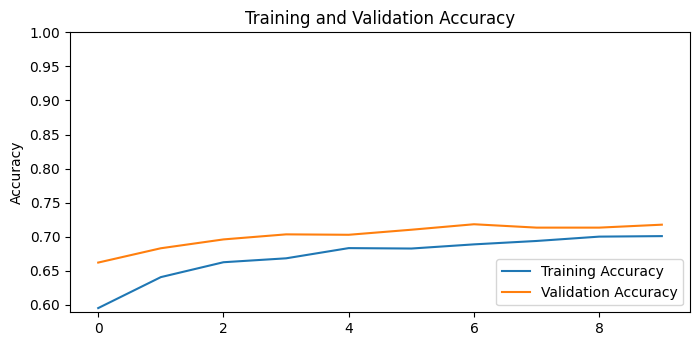

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

## Fine tuning

In [ ]:
initial_epochs = 10

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


optimizer = Adam(learning_rate= base_learning_rate/10)

# Compile the model

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Number of layers in the base model:  154
Epoch 10/20
251/251 [==============================] - 107s 403ms/step - loss: 0.8303 - accuracy: 0.7099 - val_loss: 0.8004 - val_accuracy: 0.7221
Epoch 11/20
251/251 [==============================] - 100s 399ms/step - loss: 0.7852 - accuracy: 0.7215 - val_loss: 0.7958 - val_accuracy: 0.7276
Epoch 12/20
251/251 [==============================] - 101s 401ms/step - loss: 0.7436 - accuracy: 0.7359 - val_loss: 0.7613 - val_accuracy: 0.7301
Epoch 13/20
251/251 [==============================] - 101s 400ms/step - loss: 0.7324 - accuracy: 0.7410 - val_loss: 0.7460 - val_accuracy: 0.7387
Epoch 14/20
251/251 [==============================] - 100s 399ms/step - loss: 0.7233 - accuracy: 0.7398 - val_loss: 0.7454 - val_accuracy: 0.7313
Epoch 15/20
251/251 [==============================] - 143s 567ms/step - loss: 0.7024 - accuracy: 0.7449 - val_loss: 0.7306 - val_accuracy: 0.7369
Epoch 16/20
251/251 [==============================] - 98s 388ms/step - loss:

Text(0.5, 1.0, 'Training and Validation Accuracy')

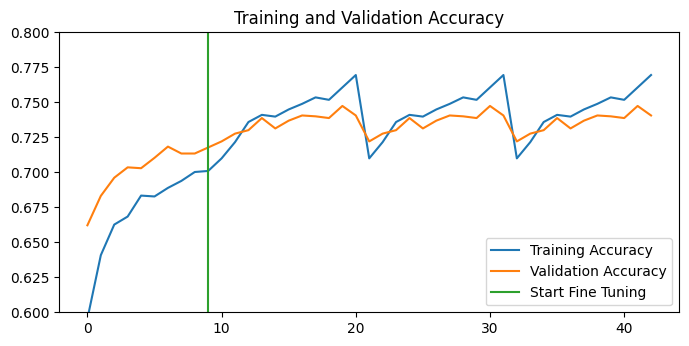

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 0.8])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
# model = load_model(base_skin_dir + '/data_gen_model.h5')
# plot_model(model)

## Model Performance

1/1 [==============================] - 0s 133ms/step


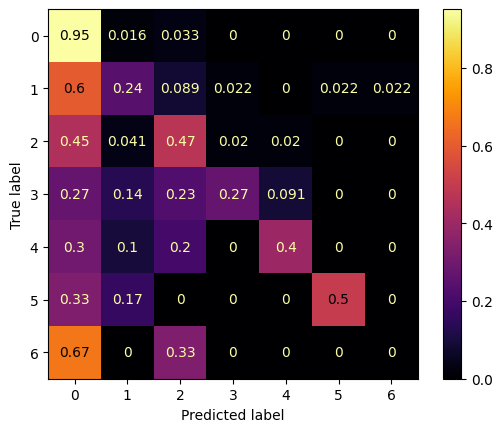

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# # convert the true and predicted labels into tensors
correct_labels = tf.concat([np.argmax(item, axis=1) for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)


ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels, normalize='true', cmap = 'inferno')
plt.grid(False)
plt.show()

In [ ]:
model.save('MobileNetFineTune.keras')